In [1]:
# %watermark -v -m -p sklearn,pandas,numpy,matplotlib,seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# I. Data Preparation
* Reading the raw data in CSV format and renaming the columns
* Extracting labels (Diagnosis) from the features and mapping classes as "Malignant -> 1" and "Benign -> 0"
* Normalizing features using MinMaxScaler

In [3]:
# Column names taken from the "Variables Table" part of the dataset source
col_names = ['ID', 'Diagnosis',
             'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1',
             'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2',
             'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']

data_df = pd.read_csv('data/wdbc.data', sep=',', names=col_names)
data_df

,ID,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [4]:
# Label extraction
features = data_df.drop(['ID'], axis=1)
labels = features.pop('Diagnosis').map({'B': 0, 'M': 1})

In [5]:
# Feature scaling
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=col_names[2:])
features

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.690000,0.428813,0.678668,0.566490,0.526948,0.296055,0.571462,0.690358,0.336364,0.132056,...,0.623266,0.383262,0.576174,0.452664,0.461137,0.178527,0.328035,0.761512,0.097575,0.105667
565,0.622320,0.626987,0.604036,0.474019,0.407782,0.257714,0.337395,0.486630,0.349495,0.113100,...,0.560655,0.699094,0.520892,0.379915,0.300007,0.159997,0.256789,0.559450,0.198502,0.074315
566,0.455251,0.621238,0.445788,0.303118,0.288165,0.254340,0.216753,0.263519,0.267677,0.137321,...,0.393099,0.589019,0.379949,0.230731,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909
567,0.644564,0.663510,0.665538,0.475716,0.588336,0.790197,0.823336,0.755467,0.675253,0.425442,...,0.633582,0.730277,0.668310,0.402035,0.619626,0.815758,0.749760,0.910653,0.497142,0.452315


# II. Determining the Number of Clusters

## II.I. Elbow Method using Inertia

<Axes: xlabel='k', ylabel='inertia'>

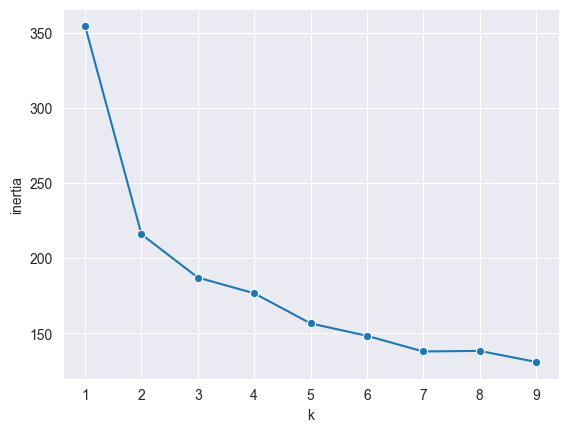

In [6]:
k_range = range(1, 10)
inertia = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit_predict(features)
    inertia.append(km.inertia_)

results = pd.DataFrame({'k': list(k_range), 'inertia': inertia}, index=list(k_range))
sns.lineplot(results, x='k', y='inertia', marker='o')

* The elbow point can be selected as <b>k=2</b>, since the change in inertia becomes less significant after that point.

## II.II. Silhouette Score

<Axes: xlabel='k', ylabel='silhouette'>

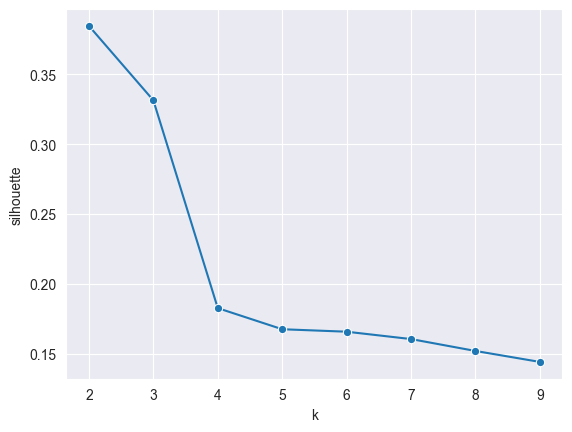

In [7]:
k_range = range(2, 10)
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    sil_score = silhouette_score(features, km.fit_predict(features))
    sil_scores.append(sil_score)

results = pd.DataFrame({'k': list(k_range), 'silhouette': sil_scores}, index=list(k_range))
sns.lineplot(results, x='k', y='silhouette', marker='o')

* While determining the number of clusters, higher silhouette score is desired. So, <b>k=2</b> is once again the best choice.

# III. Clustering and Evaluation

## III.I. K-Means
* k=2 was found as the number of clusters in the previous section, so we use it here as the parameter <b>n_clusters=2</b>.
* Using Adjusted Rand Index as the evaluation metric.

In [8]:
k_means = KMeans(n_clusters=2, random_state=0).fit(features)
k_means_rand_score = adjusted_rand_score(labels, k_means.labels_)
print('K-Means Adjusted Rand Score:', k_means_rand_score)

K-Means Adjusted Rand Score: 0.7301749027614344


## III.II. DBSCAN
* I have tried to find the optimal minPts and eps parameters within the ranges,
    *   5 <= minPts + 5*k < 500, k=0,1,2,...
    * 0.1 <= eps + 0.045*k < 1.0, k=0,1,2,...
* When evaluated with the Adjusted Rand Index metric, the best parameter selection seems to be:
    * minPts = 190
    * eps = 0.5768

In [9]:
best_parameters = {'score': 0, 'min_sample': 0, 'eps': 0}

for min_pts_test in range(5, 500, 5):
    for eps_test in np.linspace(0.1, 1.0, 20):
        dbscan = DBSCAN(min_samples=min_pts_test, eps=eps_test).fit(features)
        dbscan_rand_score = adjusted_rand_score(labels, dbscan.labels_)
        if dbscan_rand_score > best_parameters['score']:
            best_parameters = {'score': dbscan_rand_score, 'min_sample': min_pts_test, 'eps': eps_test}

best_parameters

{'score': 0.5236380226016976,
 'min_sample': 190,
 'eps': np.float64(0.5736842105263158)}

In [10]:
dbscan = DBSCAN(min_samples=best_parameters['min_sample'], eps=best_parameters['eps']).fit(features)
dbscan_rand_score = adjusted_rand_score(labels, dbscan.labels_)
print('DBSCAN Adjusted Rand Score:', dbscan_rand_score)

DBSCAN Adjusted Rand Score: 0.5236380226016976


# Visualisation on 2D Space
* To visualise the clusters on 2D, I have used PCA to get the two best components that represents the 30-dimensional space

In [11]:
def plot_on_pca(real, pred=None, title='', ax=None, legend=False):
    pca = pd.DataFrame(PCA(n_components=2, random_state=0).fit_transform(features), columns=['pca1', 'pca2'])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    ax.set_title(title)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

    pca['cluster'] = pred if pred is not None else real
    markers = style = None
    if pred is not None:
        style = 'is_correct'
        pca['is_correct'] = real == pred
        markers = {True: 'o', False: 'X'}

    sns.scatterplot(data=pca, x='pca1', y='pca2', hue='cluster', style=style, markers=markers, ax=ax, legend=False)

    if legend:
        classes = sorted(pca['cluster'].unique())
        palette = sns.color_palette(n_colors=len(classes))
        colors = {cls: palette[i] for i, cls in enumerate(classes)}
        legend_elements = [
            Line2D([], [], marker='s', color='w', label=f'Cluster - {classes[0]}',
                   markerfacecolor=colors[classes[0]], markeredgecolor='k', markersize=6, linestyle='None'),
            Line2D([], [], marker='s', color='w', label=f'Cluster - {classes[1]}',
                   markerfacecolor=colors[classes[1]], markeredgecolor='k', markersize=6, linestyle='None')
        ]
        if pred is not None:
            legend_elements.extend([
                Line2D([], [], marker='o', color='w', label='Correct',
                       markerfacecolor='gray', markeredgecolor='k', markersize=6, linestyle='None'),
                Line2D([], [], marker='x', color='w', label='Incorrect',
                       markeredgecolor='k', markersize=6, markeredgewidth=1.5, linestyle='None')
            ])
        ax.legend(handles=legend_elements)

dbscan.labels_[dbscan.labels_ == -1] = 1    # Considering the noise (label=-1) as the 2nd cluster for visualisation purposes

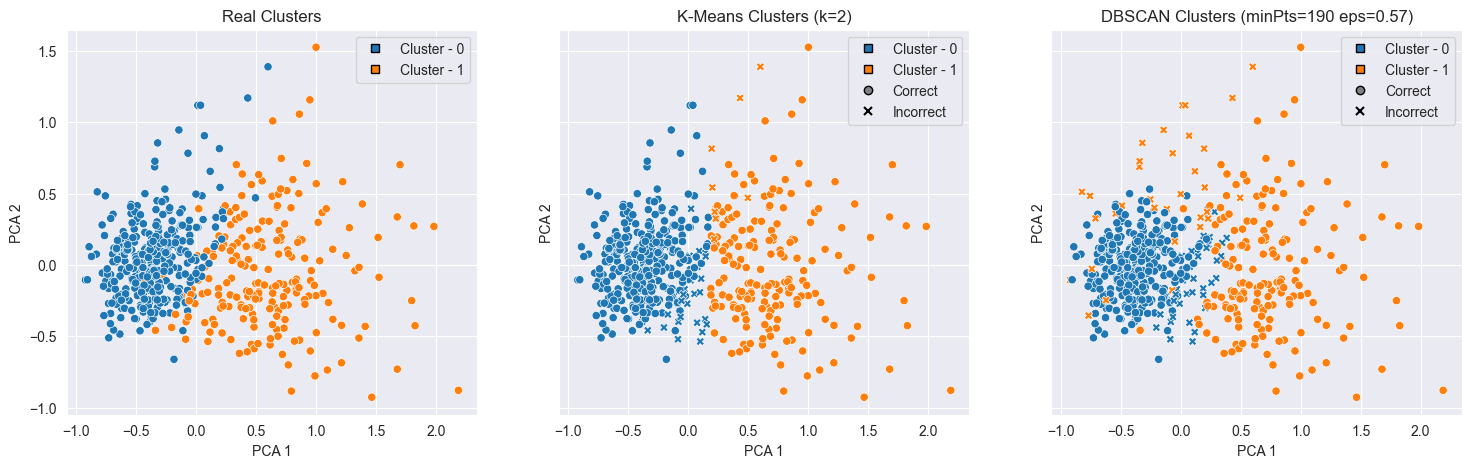

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18, 5))

plot_on_pca(labels, title='Real Clusters', ax=ax1, legend=True)
plot_on_pca(labels, k_means.labels_, title='K-Means Clusters (k=2)', ax=ax2, legend=True)
plot_on_pca(labels, dbscan.labels_, title='DBSCAN Clusters (minPts=190 eps=0.57)', ax=ax3, legend=True)